In [1]:

import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping    
from tensorflow.keras.callbacks import ReduceLROnPlateau 
import time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import kagglehub


# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\johnn\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory paths
train_dir = 'train'
test_dir = 'test'

# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 32, 32
BATCH_SIZE = 32

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to 0-1
    rotation_range=20,            # Randomly rotate images by 20 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20%
    height_shift_range=0.2,       # Randomly shift images vertically by 20%
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,               # Randomly zoom in images
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill in pixels with nearest values after transformations
)

# Only rescale for test data, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'           # For binary classification (real vs fake)
)

# Load test data without augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
# Load the validation data


# Display the class names for the training and test generators
print("Training classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Training classes: {'FAKE': 0, 'REAL': 1}
Test classes: {'FAKE': 0, 'REAL': 1}


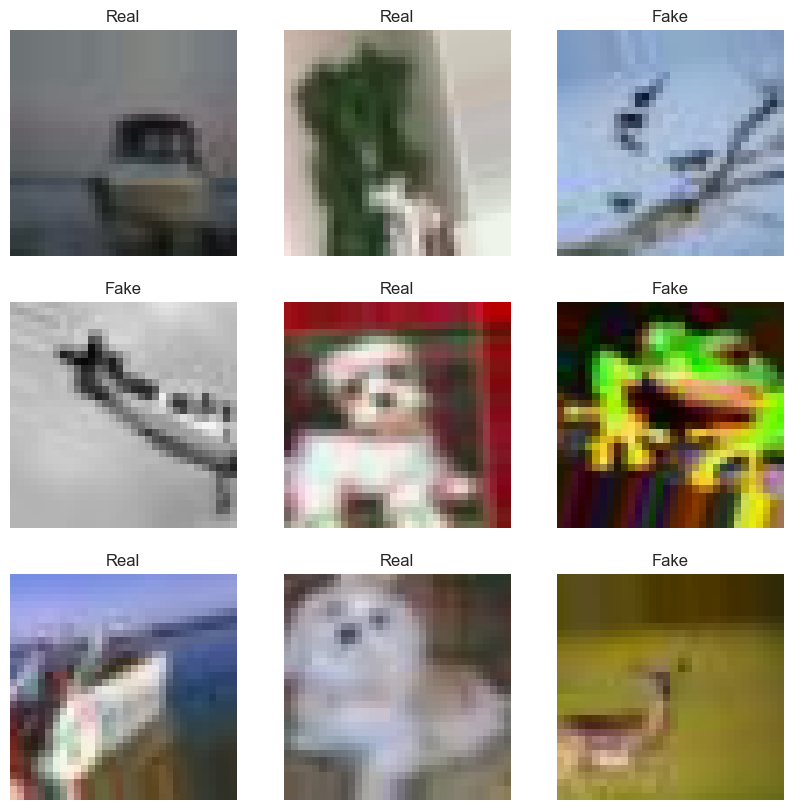

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Set up a grid to display images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Real" if labels[i] == 1 else "Fake")  # Assuming 1 = Real and 0 = Fake
    plt.axis('off')  # Hide axes for a cleaner display

plt.show()

In [4]:
import pandas as pd
import os
import tensorflow as tf

def load_and_preprocess_images(train_dir, img_size=(32 ,32)):
    # Initialize lists for storing image details
    image_names = []
    labels = []
    pixel_arrays = []
    
    # Loop through the directories to get image paths, labels, and pixel arrays
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                
                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize the pixel values
                
                # Append details to lists
                image_names.append(img_name)
                labels.append(label)
                pixel_arrays.append(img_array)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'image_name': image_names,
        'label': labels,
        'pixel_array': pixel_arrays
    })
    
    return df

# Example usage

df = load_and_preprocess_images(train_dir)


In [5]:
df.head()


,image_name,label,pixel_array
0,1000 (10).jpg,FAKE,"[[[0.44705883, 0.4392157, 0.44313726], [0.4666..."
1,1000 (2).jpg,FAKE,"[[[0.80784315, 0.8, 0.8039216], [0.84313726, 0..."
2,1000 (3).jpg,FAKE,"[[[0.6, 0.7254902, 0.8156863], [0.50980395, 0...."
3,1000 (4).jpg,FAKE,"[[[0.7058824, 0.79607844, 0.27058825], [0.6823..."
4,1000 (5).jpg,FAKE,"[[[0.019607844, 0.09803922, 0.0], [0.0, 0.0509..."


In [6]:
print(df['label'].value_counts())

label
FAKE    50000
REAL    50000
Name: count, dtype: int64


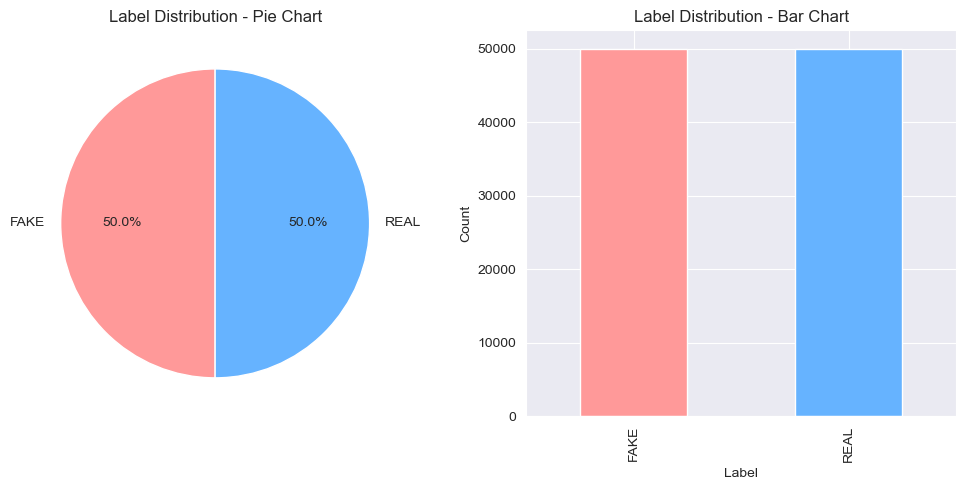

In [7]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Pie Chart')
plt.ylabel('')

# Plot a bar chart
plt.subplot(1, 2, 2)
label_counts.plot.bar(color=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Bar Chart')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
print("Null counter: ",df.isnull().sum())
print("Shape of the dataframe: ",df.shape)


Null counter:  image_name     0
label          0
pixel_array    0
dtype: int64
Shape of the dataframe:  (100000, 3)


In [9]:
X = df['pixel_array']

X

0        [[[0.44705883, 0.4392157, 0.44313726], [0.4666...
1        [[[0.80784315, 0.8, 0.8039216], [0.84313726, 0...
2        [[[0.6, 0.7254902, 0.8156863], [0.50980395, 0....
3        [[[0.7058824, 0.79607844, 0.27058825], [0.6823...
4        [[[0.019607844, 0.09803922, 0.0], [0.0, 0.0509...
                               ...                        
99995    [[[0.6627451, 0.6666667, 0.6431373], [0.686274...
99996    [[[0.9529412, 0.9490196, 0.59607846], [0.96078...
99997    [[[0.39215687, 0.57254905, 0.7647059], [0.4156...
99998    [[[0.9882353, 1.0, 1.0], [0.9843137, 1.0, 1.0]...
99999    [[[0.60784316, 0.627451, 0.6392157], [0.607843...
Name: pixel_array, Length: 100000, dtype: object

In [10]:
y = df['label']

y

0        FAKE
1        FAKE
2        FAKE
3        FAKE
4        FAKE
         ... 
99995    REAL
99996    REAL
99997    REAL
99998    REAL
99999    REAL
Name: label, Length: 100000, dtype: object

In [11]:

oversampler = RandomOverSampler(sampling_strategy="auto")

X, y = oversampler.fit_resample(X.values.reshape(-1,1), y)

In [12]:
X

array([[array([[[0.44705883, 0.4392157 , 0.44313726],
                [0.46666667, 0.45882353, 0.4627451 ],
                [0.45882353, 0.45882353, 0.4509804 ],
                ...,
                [0.4862745 , 0.47058824, 0.46666667],
                [0.41568628, 0.4       , 0.39607844],
                [0.21176471, 0.19607843, 0.19215687]],

               [[0.49803922, 0.49019608, 0.49411765],
                [0.49803922, 0.49019608, 0.49411765],
                [0.4862745 , 0.4862745 , 0.4862745 ],
                ...,
                [0.40392157, 0.3882353 , 0.38431373],
                [0.31764707, 0.3019608 , 0.29803923],
                [0.18039216, 0.16470589, 0.16078432]],

               [[0.52156866, 0.5137255 , 0.5176471 ],
                [0.5019608 , 0.49411765, 0.49803922],
                [0.49411765, 0.4862745 , 0.49019608],
                ...,
                [0.28235295, 0.26666668, 0.25490198],
                [0.19607843, 0.18039216, 0.16862746],
               

In [13]:
y

0        FAKE
1        FAKE
2        FAKE
3        FAKE
4        FAKE
         ... 
99995    REAL
99996    REAL
99997    REAL
99998    REAL
99999    REAL
Name: label, Length: 100000, dtype: object

In [14]:
print("X.shape =", X.shape)

print("y.shape =", y.shape)

X.shape = (100000, 1)
y.shape = (100000,)


In [15]:
X = pd.Series(X.flatten())

X


0        [[[0.44705883, 0.4392157, 0.44313726], [0.4666...
1        [[[0.80784315, 0.8, 0.8039216], [0.84313726, 0...
2        [[[0.6, 0.7254902, 0.8156863], [0.50980395, 0....
3        [[[0.7058824, 0.79607844, 0.27058825], [0.6823...
4        [[[0.019607844, 0.09803922, 0.0], [0.0, 0.0509...
                               ...                        
99995    [[[0.6627451, 0.6666667, 0.6431373], [0.686274...
99996    [[[0.9529412, 0.9490196, 0.59607846], [0.96078...
99997    [[[0.39215687, 0.57254905, 0.7647059], [0.4156...
99998    [[[0.9882353, 1.0, 1.0], [0.9843137, 1.0, 1.0]...
99999    [[[0.60784316, 0.627451, 0.6392157], [0.607843...
Length: 100000, dtype: object

In [16]:
import numpy as np

# Assuming X is a list or Series with each element as a 3D array for a single RGB image
X = np.array(X.tolist())  # Convert to numpy array if X is in another format

# Check if the shape is compatible with reshaping
if X.shape[1:] == (32, 32, 3):  # Each image is 32x32 pixels with 3 channels (RGB)
    X = X.reshape(-1, 32, 32, 3)
    print("Final shape of X:", X.shape)
else:
    print("Error: X entries do not match the expected shape for 32x32 RGB images.")


Final shape of X: (100000, 32, 32, 3)


In [17]:
print(X.shape)
print(y.shape)

(100000, 32, 32, 3)
(100000,)


In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 32, 32, 3)
(20000, 32, 32, 3)
(80000,)
(20000,)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (0 or 1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

c:\Users\johnn\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Map labels to binary format
y_test = np.where(y_test == 'REAL', 1, 0)
y_train = np.where(y_train == 'REAL', 1, 0)



In [22]:
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Reduce learning rate when a metric has stopped improving.
early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 10,
                               mode = "auto",
                               restore_best_weights = True)

                        

In [23]:
reduce_learning_rate = ReduceLROnPlateau(monitor ="val_accuracy",
                                         factor = 0.5,
                                         verbose = 1,
                                         min_lr = 0.00001)

In [24]:
class_weights = {0: 1.0, 1: 1.0}
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks = [early_stopping, reduce_learning_rate], class_weight = class_weights, validation_data = test_generator)

Epoch 1/100
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7601 - loss: 0.4856

c:\Users\johnn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 27ms/step - accuracy: 0.7601 - loss: 0.4855 - val_accuracy: 0.8687 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8667 - loss: 0.3229 - val_accuracy: 0.8826 - val_loss: 0.2751 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.8851 - loss: 0.2778 - val_accuracy: 0.8903 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8966 - loss: 0.2559 - val_accuracy: 0.9068 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.9000 - loss: 0.2460 - val_accuracy: 0.8757 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9061 - loss: 0.2360 - val_accuracy: 0.8977 - val_loss: 0.2506 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0

In [ ]:
model.save("nn.h5")

In [29]:
new = keras.models.load_model("nn.h5")
new.evaluate(X_test, y_test, verbose = 2)


625/625 - 5s - 8ms/step - accuracy: 0.9376 - loss: 0.1610


[0.16095642745494843, 0.9376000165939331]

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


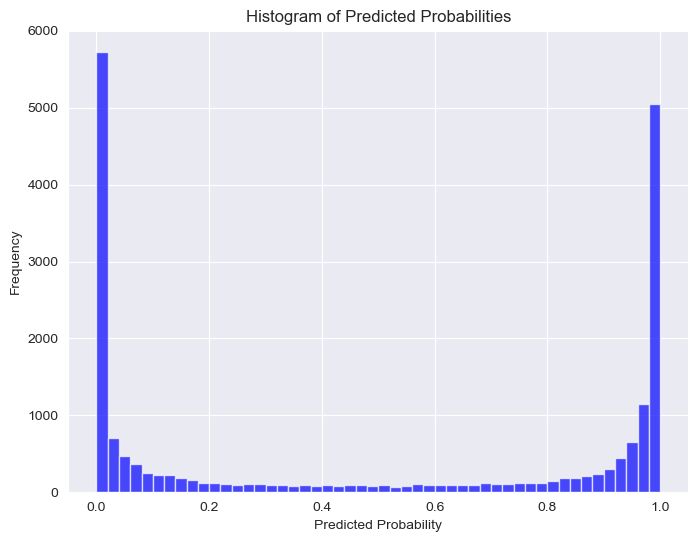

In [30]:
# Prediction analysis
y_pred = new.predict(X_test)

# Convert to binary so we can use in confusion_matrix
y_pred_binary = (y_pred > 0.5).astype(int)

plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Evaluation model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9376
Precision: 0.9309
Recall: 0.9449
F1 Score: 0.9378


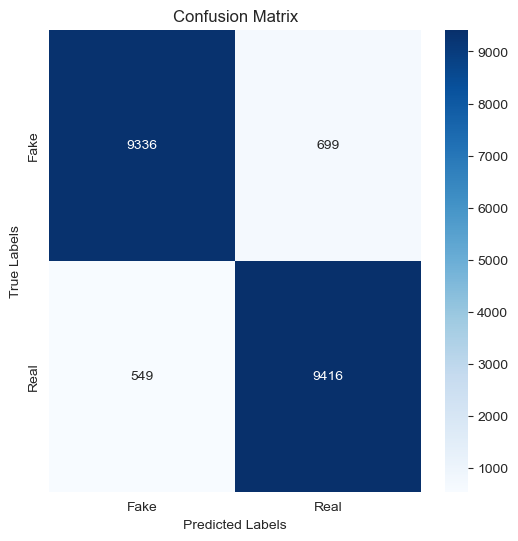

In [32]:
# Confusion Matrix

model_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 6))
sns.heatmap(model_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = 'real2'
test_dir = 'fake2'

# Preprocessing the data
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize as per your model's input
    batch_size=32,
    class_mode='binary'  # For binary classification
)
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
